In [1]:
import numpy as np
from tqdm import tqdm
import scipy.optimize as opt
from scipy.stats import norm, beta, gamma

import matplotlib.pyplot as plt
import sys
sys.path.append('C:/Users/Shawn/Documents/Python/pyEM')
from pyEM.math import softmax, norm2beta, norm2alpha, calc_fval
from pyEM.fitting import EMfit

In [2]:
def simulate(params, nblocks=3, ntrials=24):
    nsubjects = len(params)
    noise = 1.0  # fixed noise for simplicity
    dt = 0.01
    
    all_decisions = []
    all_response_times = []
    
    for simS in range(nsubjects):
        drift, thresh, ndt = params[simS]
        decisions = np.zeros((nblocks, ntrials))
        response_times = np.zeros((nblocks, ntrials))
        
        for b in range(nblocks):
            for t in range(ntrials):
                # Initialize variables
                x = 0
                t_time = 0
                
                # Accumulate evidence
                while abs(x) < thresh:
                    x += drift * dt + noise * np.sqrt(dt) * np.random.randn()
                    t_time += dt
                    
                # Determine decision
                decisions[b, t] = 1 if x >= thresh else 0
                response_times[b, t] = t_time + ndt
                
        all_decisions.append(decisions)
        all_response_times.append(response_times)
    
    return all_decisions, all_response_times

def fit(params, choices, response_times, prior=None, output='npl'):

    drift, thresh, ndt = params
    noise = 1.0  # fixed noise for simplicity
        
    nblocks, ntrials = choices.shape
    ch_prob     = np.zeros((nblocks, ntrials,   2))
    negll  = 0
    for b in range(nblocks):
        for t in range(ntrials):
            this_choice = choices[b, t]
            rt = response_times[b, t] - ndt
            if rt < 0:
                return 100000  # invalid non-decision time
            
            # Compute drift diffusion probability using approximations
            p_up = 1 / (1 + np.exp(-2 * drift * thresh / (noise**2)))
            ch_prob[b, t, 0] = p_up
            ch_prob[b, t, 1] = 1 - p_up
            p_correct = p_up if this_choice == 1 else 1 - p_up
            negll += -np.log(p_correct)
        
    # CALCULATE NEGATIVE POSTERIOR LIKELIHOOD FROM NEGLL AND PRIOR (OR NEGLL)
    if (output == 'npl') or (output == 'nll'):
        fval = calc_fval(negll, params, prior=prior, output=output)
        return fval
    
    elif output == 'all':
        subj_dict = {'params'        : [drift, thresh, ndt],
                     'ch_prob'       : ch_prob, 
                     'choices'       : choices, 
                     'response_times': response_times, 
                     'negll'         : negll}
        return subj_dict

In [3]:
# Generate subject-specific parameters
nsubjects = 150
betamin, betamax = 0.75, 10
alphamin, alphamax = 0.05, 0.95

params = np.ones((nsubjects, 3))  # drift, thresh, ndt
for simS in tqdm(range(nsubjects)):
    # For drift (analogous to beta), sample from a normal distribution and transform
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm.rvs(0, scale=1)
    
    # For threshold (analogous to alpha), sample from a beta distribution and transform
    params[simS, 1] = beta.rvs(1.1, 1.1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = beta.rvs(1.1, 1.1)
    
    # For non-decision time, sample from a uniform distribution
    params[simS, 2] = np.random.uniform(0.2, 0.5)

# Generate simulated data
sim_choices, sim_rts = simulate(params, nblocks=3, ntrials=24)

100%|██████████| 150/150 [00:00<00:00, 5367.72it/s]


In [4]:
# create a list of lists with choices and rewards for each subject
all_data = []
for idx, (choices, rts) in enumerate(zip(sim_choices, sim_rts)):
    all_data += [[choices, rts]]

In [5]:
param_names = ['drift', 'thresh', 'ndt']
output_dict = EMfit(all_data, fit, param_names, mstep_maxit=100)
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = output_dict.values()

9090.656 (000), 5712.970 (001), 5560.802 (002), 5477.306 (003), 5438.119 (004), 5412.037 (005), 5393.349 (006), 5373.356 (007), 5358.927 (008), 5340.588 (009), 5319.319 (010), 5298.918 (011), 5292.666 (012), 5286.648 (013), 5283.795 (014), 5280.682 (016), 5279.938 (050), 5279.675 (053), 5278.474 (090), -MAXIMUM NUMBER OF ITERATIONS REACHED



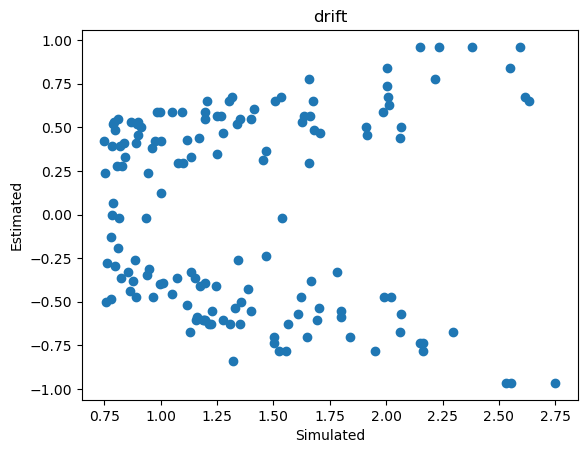

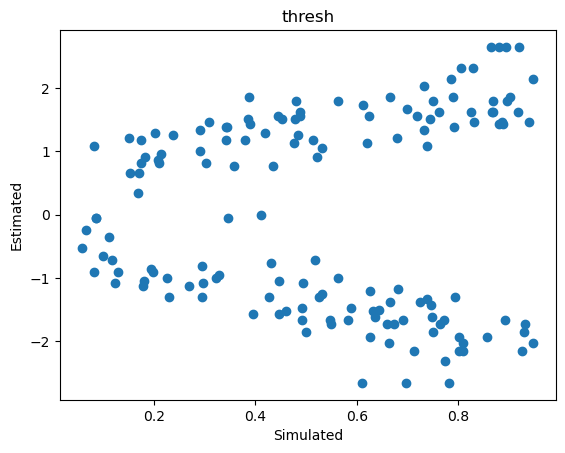

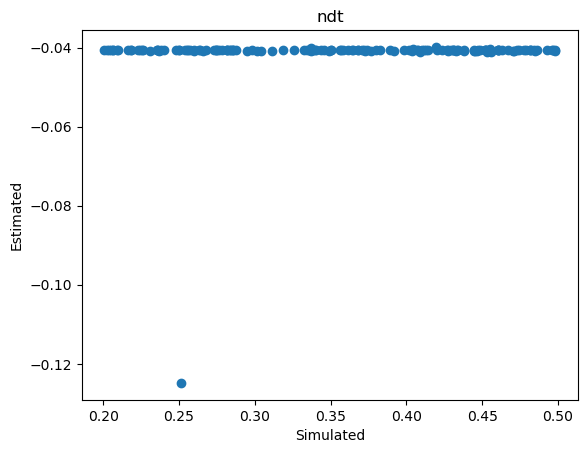

In [7]:
# plot simulated vs estimated parameters `m`
for i, param_name in enumerate(param_names):
    plt.figure()
    plt.scatter(params[:, i], m[i, :])
    plt.xlabel('Simulated')
    plt.ylabel('Estimated')
    plt.title(param_name)
    plt.show()